<a href="https://colab.research.google.com/github/ArkS0001/Algorithmic-Baby-Maker/blob/main/baby_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a cyclical learning rate scheduler
def cyclical_learning_rate(epoch, lr):
    max_lr = 0.1
    min_lr = 0.001
    cycle_length = 10
    return min_lr + (max_lr - min_lr) * abs((epoch % cycle_length) / cycle_length - 0.5)

# Neural Network Model
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),  # Initial forgetting mechanism

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and train the model
def train_model(X_train, y_train, X_val, y_val):
    input_dim = X_train.shape[1]
    num_classes = y_train.shape[1]

    model = create_model(input_dim, num_classes)
    optimizer = Adam(learning_rate=0.01)  # High initial learning rate

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Cyclical learning rate callback
    clr_callback = LearningRateScheduler(cyclical_learning_rate)

    # Train the model with dynamic learning rates
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[clr_callback])
    return model, history

# Simulate Unlearning
def simulate_unlearning(model, X_train, y_train):
    # Example: Pruning less important weights
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            threshold = 0.05  # Define a threshold for pruning
            weights[abs(weights) < threshold] = 0
            layer.set_weights([weights, biases])

    # Fine-tune the model after pruning
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Input,
    Add,
    Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer
import numpy as np

# Cyclical Learning Rate Scheduler
def cyclical_learning_rate(epoch, lr):
    max_lr = 0.1
    min_lr = 0.001
    cycle_length = 10
    return min_lr + (max_lr - min_lr) * abs((epoch % cycle_length) / cycle_length - 0.5)

# Custom Attention Layer
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)
        self.attention = Attention()

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)  # Add sequence length dimension
        x = self.attention([x, x])          # Self-attention
        x = tf.squeeze(x, axis=1)          # Remove sequence length dimension
        return x

# Residual Block with Custom Attention
def residual_block(x, units, dropout_rate=0.2):
    shortcut = Dense(units, activation=None, kernel_regularizer=l2(0.01))(x)  # Match dimensions

    # Main path
    x = Dense(units, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Custom Attention Mechanism
    x = CustomAttention()(x)

    # Skip Connection
    x = Add()([shortcut, x])  # Ensure shapes match
    x = Activation("relu")(x)
    return x

# Complex Neural Network
def create_complex_model(input_dim, num_classes):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)

    # Add multiple residual blocks
    for _ in range(3):
        x = residual_block(x, 128, dropout_rate=0.3)

    # Output layer
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Unlearning Phase: Pruning
def prune_weights(model, pruning_threshold=0.05):
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            weights[np.abs(weights) < pruning_threshold] = 0
            layer.set_weights([weights, biases])
    return model

# Training with Cyclical Learning Rate
def train_model(X_train, y_train, X_val, y_val):
    input_dim = X_train.shape[1]
    num_classes = y_train.shape[1]

    model = create_complex_model(input_dim, num_classes)
    optimizer = Adam(learning_rate=0.01)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Cyclical learning rate callback
    clr_callback = LearningRateScheduler(cyclical_learning_rate)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[clr_callback],
    )
    return model, history

# Fine-Tune After Unlearning
def fine_tune_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)
    return model

# Example Dataset (e.g., MNIST)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# Train and Prune
model, history = train_model(X_train, y_train, X_val, y_val)
model = prune_weights(model)
model = fine_tune_model(model, X_train, y_train, X_val, y_val)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4071 - loss: 9.3240 - val_accuracy: 0.4316 - val_loss: 2.7319 - learning_rate: 0.0505
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5349 - loss: 2.0802 - val_accuracy: 0.3948 - val_loss: 2.4204 - learning_rate: 0.0406
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5773 - loss: 1.6941 - val_accuracy: 0.5834 - val_loss: 1.7084 - learning_rate: 0.0307
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6368 - loss: 1.4037 - val_accuracy: 0.6658 - val_loss: 1.2451 - learning_rate: 0.0208
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6883 - loss: 1.1209 - val_accuracy: 0.7502 - val_loss: 0.9234 - learning_rate: 0.0109
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7376 - loss: 0.9021 - val_accuracy: 0.8028 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7094 - loss: 1.0468 

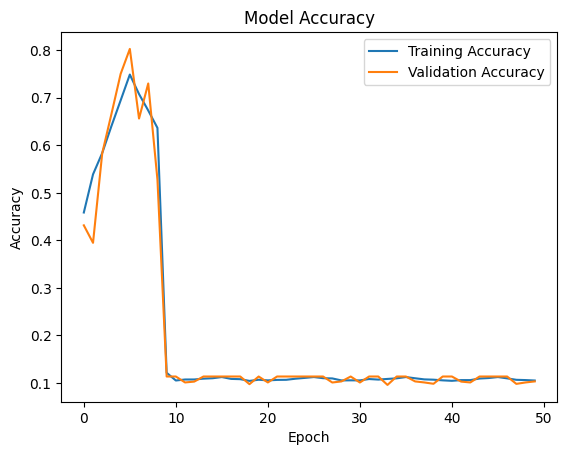

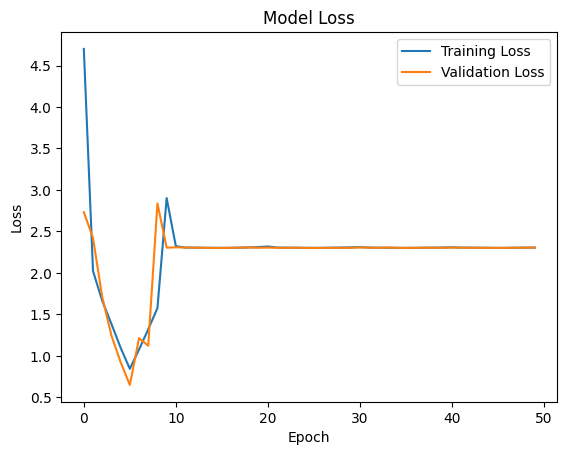

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    LSTM,
    Attention,
    Input,
    BatchNormalization,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Cyclical Learning Rate Scheduler
def cyclical_learning_rate(epoch, lr):
    max_lr = 0.1
    min_lr = 0.001
    cycle_length = 10
    return min_lr + (max_lr - min_lr) * abs((epoch % cycle_length) / cycle_length - 0.5)

# Child Brain Model
def child_brain_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Sensory Input: Convolutional Layer for Vision-like Processing
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Attention Mechanism (Focus)
    query = Dense(128, activation='relu')(x)
    key = Dense(128, activation='relu')(x)
    value = Dense(128, activation='relu')(x)
    attention_output = Attention()([query, key, value])

    # Memory Layer (Short-term Memory)
    memory_output = LSTM(128, return_sequences=False)(attention_output)

    # Decision-Making Layer
    decision = Dense(256, activation='relu')(memory_output)
    decision = Dropout(0.3)(decision)
    outputs = Dense(num_classes, activation='softmax')(decision)

    model = Model(inputs, outputs)
    return model

# Training and Forgetting (Pruning)
def train_and_prune(X_train, y_train, X_val, y_val):
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    # Create the model
    model = child_brain_model(input_shape, num_classes)
    optimizer = Adam(learning_rate=0.01)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Cyclical Learning Rate Callback
    clr_callback = LearningRateScheduler(cyclical_learning_rate)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[clr_callback]
    )

    # Simulate forgetting with pruning
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            threshold = 0.05  # Pruning threshold
            weights[np.abs(weights) < threshold] = 0
            layer.set_weights([weights, biases])

    # Fine-tune after pruning
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    return model, history

# Example Dataset (MNIST)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255.0
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1) / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# Train and Evaluate
model, history = train_and_prune(X_train, y_train, X_val, y_val)

# Evaluate Final Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")


ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)